Lotteries are a reasonably fair way to allocate scarce resources. One interesting feature of lotteries, however, is that they can quickly become unfair when they happen on a repeated basis.

For instance, suppose we repeatedly run a lottery with 100 entrants and only 7 winners per lottery. If we run the lottery thirty times and count up how often each of the hundred entrants won, we can immediately see that some entrants win the lottery a whole bunch and some don't win it all.

/home/alex/anaconda3/envs/lottery/lib/python3.12/site-packages/plotnine/stats/stat_count.py:70: FutureWarning: The provided callable <function sum at 0x75e6d217e160> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.


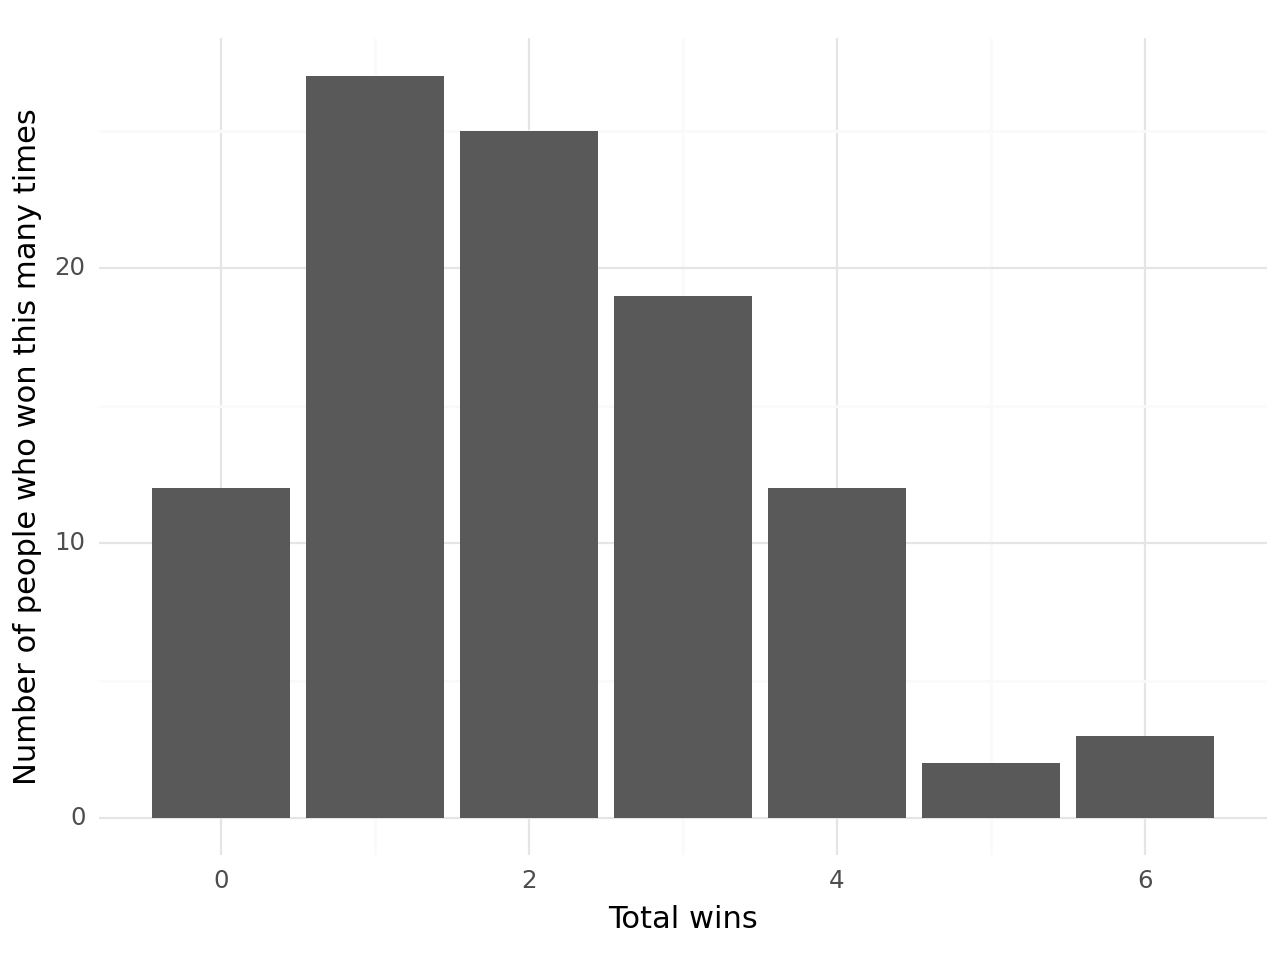

<Figure Size: (640 x 480)>

In [64]:
import numpy as np
import pandas as pd
from plotnine import ggplot, aes, geom_bar, labs, theme_minimal

rng = np.random.default_rng(27)

num_entrants = 100
num_winners_per_lottery = 7
num_lotteries = 30

winners = np.zeros((num_entrants, num_lotteries))

for lottery in range(num_lotteries):
    winner_idx = rng.choice(num_entrants, size=num_winners_per_lottery, replace = False)
    winners[winner_idx, lottery] = 1

def plot_win_distribution(total_wins: np.array):
    
    total_wins_df = pd.DataFrame(total_wins, columns=['total_wins'])
    
    plot =  (
        ggplot(total_wins_df) +
        aes(x='total_wins') +
        geom_bar() +
        labs(
            x='Total wins',
            y='Number of people who won this many times'
        ) +
        theme_minimal()
    )
    
    return plot

plot_win_distribution(winners.sum(axis = 1))

In the example after, there are three entrants who won six times, but over ten entrants who have never won at all. This no longer feels like a fair way to allocate resources, which is one of the main reasons to run a lottery in the first place.

Repeated lotteries come up in a number of places, most intriguingly, I think, for recurring events that have attendance limits. Things like the New York Marathon or Burning Man. When the number of applicants to these events is roughly the same order of magnitude as the number of available spots, outcomes from repeated entrance lotteries start looking pretty unfair. In contrast, if almost no one gets into an event (or almost every does) repeated winners (or losers) are pretty rare.

Is there a way to make repeated lotteries more fair? A couple months ago I started thinking about this idea, and after failing to come up with anything particularly satisfying, I reached out to [Bailey Flanigan](http://baileyflanigan.com/), a computer scientist working on fair allocation problems, especially in civic contexts. Less than 24 hours later after receiving my email, Bailey sent me back several pages of notes on the problem, and suggested an approach for running the lotteries that I will introduce in just a moment. 

Aside: this is a really fun problem to think about, and I strongly encourage you to read Bailey's papers if this kind of thing is up your alley. I also want to say that it was incredibly fun to brainstorm back and forth with Bailey, and if you get the chance to work with her at all, I highly recommend it. I don't want to claim any intellectual credit for the her problem formalization and proposed solution, but throughout the rest of the post I will highlight some dead ends I went down why they don't work.

Okay, so, formalizing the problem. Suppose there is universe $U$ of possible entrants indexed by $i = 1, 2, 3, ...$, and we run want to run lotteries indexed by $t = 1, ..., T$. For each lottery $t$, there are $N_t$ entrants and $K_t$ available slots. In each lottery, we assume each applicant has a score $s_i^t$, which is typically just a binary indicator of whether or not they applied. But you can also run weighted lotteries by allowing $s_i^t to be arbitrary positive numbers, so that applicants with highly scores (for a given lottery) are more likely to selected. For instance, in the New York Marathon, you could score entrants according to their past marathon performance to ensure that a number of world-class athletes end up admitted to the event. The idea is then that, for the $t^{th}$ lottery, we think that entrant $i$ is should be probabilistically allocated a portion $s_i^t / \sum_{i \in U} s_i^t$ of the $K_t$ available slots. Letting $w_i^t$ denote whether or not entrant $i$ won at time $t$, we can characterize the worst cumulative unfairness up to time $t'$ as
$$
\max_{i \in U} \left| \sum_{t = 1}^{t'} \underbrace{\frac{s_i^t}{\sum_{i \in U} s_i^t}}_\text{fair portion of seats} \cdot \underbrace{K_t}_\text{available seats} - \underbrace{w_i^t}_\text{seat received} \right|
$$
The idea is that we look at how many seats each entrant should been allocated up until $t'$ versus how many seats they actually got, and then we consider the largest absolute deviation from the fair allocation. This fairness objective penalizes unfairness both in the sense of receiving too great or too little of an allocation.

In order to actually run a lottery, we suppose that we have seen results from the first $t'$ lotteries, then our goal is design marginal selection probabilities $\pi_i^t = \mathbb E(w_i^t = 1)$ such that $\sum_{i \in U} \pi_i^t = K_t$, at which point we will sample $w_i^t$ according to $\pi_i^t$. We want the $\pi_i^t$ to minimize
$$
\max_{i \in U} \left|
    \underbrace{\sum_{t = 1}^{t'} \frac{s_i^t}{\sum_{i \in U} s_i^t} \cdot K_t - w_i^t}_\text{unfairness so fair} +
    \underbrace{\frac{s_i^t}{\sum_{i \in U} s_i^t} \cdot K_t - \underbrace{\pi_i^t}_\text{win probability}}_\text{expected upcoming unfairness}
\right|
$$
Finding the $\pi_i^t$ can be solved by projected gradient descent, and so I took this opportunity to learn just enough [Jax](https://jax.readthedocs.io/en/latest/) to get the job done.


It looks like a li

Note: you can add entrant quotas to the above formalization, but then things quickly get above my pay grade and you have to solve a somewhat involved discrete optimization problem.


In [65]:
import jax.numpy as jnp

def unfairness_weighted(current_win_probability, lottery_sizes, scores, received):
    """
    Let |U| denote the size of entrant candidate pool and t denote the index of the current lottery
    
    In practice you might want to validate inputs by checking that ``current_win_probability`` has values in [0, 1]
    and sums to the current lottery size, but this seemed to involve more Jax shenanigans than I had time
    for when I originally this code (see https://jax.readthedocs.io/en/latest/debugging/checkify_guide.html)
    
    Inputs:
        - current_win_probability: (|U|)-Array corresponding to pi^t
        - lottery_sizes: (t)-Array corresponding to K^1, ..., K^t
        - scores: (|U|, t)-Array containing values of s_i^t
        - received: (|U|)-Array containing the number of times each entrant has won so far, or \sum_{t=1}^t w_i^t
            with some abuse of notation 
    Output:
        - (1)-Array scalar loss
    """    
    scores_normed = scores / scores.sum(axis = 0)
    allocation = scores_normed @ lottery_sizes.reshape(-1, 1) + current_win_probability
    individual_deviations = received - allocation
    loss = -jnp.max(jnp.abs(individual_deviations))
    return loss

<>:4: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_7012/2548754704.py:4: SyntaxWarning: invalid escape sequence '\s'


To perform the projected gradient descent, we also need a projection operator that takes an arbitrary $\pi$ and projects it onto the intersection of the simplex summing to $K_t$, and $[0, 1]^{|U|}$. 

In [66]:
def projection_simplex_clip(r, simplex_sum=1):
    """
    Projects a real-valued vector ``r`` onto the simplex, with the constraint the elements
    of the simplex sum to ``simplex_sum``, and all entries of the vector must
    be between 0 and 1.

    Modified from http://www.ryanhmckenna.com/2019/10/projecting-onto-probability-simplex.html
    """
    lambdas = jnp.append(-r, 1 - r)
    idx = jnp.argsort(lambdas)
    lambdas = lambdas[idx]
    active = jnp.cumsum((idx < r.size) * 2 - 1)[:-1]
    diffs = jnp.diff(lambdas, n=1)
    totals = jnp.cumsum(active * diffs)
    i = jnp.searchsorted(totals, simplex_sum)
    lam = (simplex_sum - totals[i]) / active[i] + lambdas[i + 1]
    p = jnp.clip(r + lam, 0, 1)
    return p / p.sum() * simplex_sum  # re-normalization not strictly necessary

At this point there it seems like we just need some scores and a way to perform the actually sampling and we're all done. But it turns out that actually sampling according to $\pi^t$ is not immediate:

- If you flip a coin with probability $\pi_i^t$ for $i \in U$, and the coin flips are all independent, there is no way to guarantee that you respect capacity constraints and have exactly $K_t$ winners.
- If you perform weighted random sampling with replacement, you might select the same entrant several times
- If you perform weighted random sampling without replacement, for many sampling algorithms the weights are the marginal selection probabilities, and in fact it may even be computational infeasible to compute the marginal selection probabilities given the weights

It turns out there is a whole literature on "randomized rounding" that has some tools for sampling without replacement according to marginal probabilities of selection, but I cannot describe this literature as particularly approachable to those outside the discrete optimization community. In any case, there's a method called randomized pipage rounding that does what we need (see the Appendix of @karimi2017, and reference trail therein).

In [67]:
def randomized_pipage_rounding(x):
    """
    Fast pipage rounding implementation for uniform matroid

    From https://github.com/bwilder0/clusternet with trivial modification
    See Randomized Pipage Rounding algorithm in http://arxiv.org/abs/1711.01566
    """
    i = 0
    j = 1
    x = np.array(x)
    for _ in range(len(x) - 1):
        if x[i] == 0 and x[j] == 0:
            i = max((i, j)) + 1
        elif x[i] + x[j] < 1:
            if rng.random() < x[i] / (x[i] + x[j]):
                x[i] = x[i] + x[j]
                x[j] = 0
                j = max((i, j)) + 1
            else:
                x[j] = x[i] + x[j]
                x[i] = 0
                i = max((i, j)) + 1
        else:
            if rng.random() < (1 - x[j]) / (2 - x[i] - x[j]):
                x[j] = x[i] + x[j] - 1
                x[i] = 1
                i = max((i, j)) + 1

            else:
                x[i] = x[i] + x[j] - 1
                x[j] = 1
                j = max((i, j)) + 1
    # round one last time to make result look clean
    return np.round(x)

I was quite surprised at how hard it was to find the implementation above, and also by how little use randomized rounding seems to get within statistics proper. In any case, we can briefly check that the sampler is working as desired.

In [68]:
pi_test = np.array([0.1, 0.3, 0.4, 0.8, 0.4])  # sums to 2.0

reps = 1000
total = np.zeros_like(pi_test)
for i in range(reps):
    total += randomized_pipage_rounding(pi_test)

# deviations from marginal selection probabilities are small
total / reps - pi_test

array([ 0.007,  0.038, -0.031, -0.006, -0.008])

At this point I implemented the actual lottery logic, in a Python class called `LotteryPool`.

In [80]:
import logging
import matplotlib.pyplot as plt
import seaborn as sns
from jaxopt import ProjectedGradient

logger = logging.getLogger("lottery_pool_logger")  
logging.basicConfig(level="WARNING")

class LotteryPool:
    """
    win_probability: 2d float array of marginal win probabilities (num_entrants x num_lotteries)
    winners: 2d binary array of winners (num_entrants x num_lotteries)
    scores: 2d float array of application scores (positive values only) (num_entrants x num_lotteries)
    lottery_size: 1d integer vector of number of winners per lottery (num_lotteries)    
    note that both num_entrants and num_lotteries are changing over time
    """
    
    def __init__(self, pool_name : str):
        
        self.pool_name = pool_name        
        self.first_lottery = True
        self.scores = None
        self.lottery_sizes = None
        self.winners = None
        self.win_probabilities = None
    
    def entrant_sitrep(self, entrant_index : int):
        # print pool name
        # entries, portions of slots allocated by lottery, deviation from this, relative position (and rank) relative to the rest of entrants
        pass
    
    def _add_lottery_data(self, current_scores, current_lottery_size):
        """
        scores - 1d jax array
        lottery_size - 1x1 jax array
        """
        num_entrants = len(current_scores)
        
        if self.first_lottery:
            self.lottery_sizes = jnp.asarray(current_lottery_size)
            self.scores = current_scores.reshape(-1, 1)
        # repeated lottery
        else:
            self.lottery_sizes = jnp.append(self.lottery_sizes, current_lottery_size)
            num_pool_members = self.scores.shape[0]
            
            if num_entrants < num_pool_members:
                raise ValueError(
                    f"""
                    Must provide a score for each member of the pool. There are {num_pool_members}
                    pool members, but you only provided scores for {num_entrants} entrants.
                    """
                    )
                
            elif num_entrants > num_pool_members:
                num_new_entrants = num_entrants - num_pool_members
                num_lotteries = self.scores.shape[1]
                logger.warning(f"Since there are {num_new_entrants} new pool members, retroactively setting past scores, win probabilities and wins for these members to zero for {num_lotteries} lotteries")
                
                retroactive_scores = jnp.zeros((num_new_entrants, num_lotteries))
                retroactive_winners = jnp.zeros((num_new_entrants, num_lotteries))
                retroactive_win_probabilities = jnp.zeros((num_new_entrants, num_lotteries))
                
                self.scores = jnp.vstack((self.scores, retroactive_scores))  
                self.winners = jnp.vstack((self.winners, retroactive_winners))  
                self.win_probabilities = jnp.vstack((self.win_probabilities, retroactive_win_probabilities))   
                        
                
            self.scores = jnp.hstack((self.scores, current_scores.reshape(-1, 1)))
        
    def _record_results(self, current_fair_probabilities, current_winners):
        
        if self.first_lottery:
            self.win_probabilities = current_fair_probabilities.reshape(-1, 1)
            self.winners = current_winners.reshape(-1, 1)
        else:
            self.win_probabilities = jnp.hstack((self.win_probabilities, current_fair_probabilities.reshape(-1, 1)))
            self.winners = jnp.hstack((self.winners, current_winners.reshape(-1, 1)))        
    
    def run_lottery(self, scores, lottery_size: int):
        """
        scores - 1d jax array
        """
        
        self._add_lottery_data(scores, lottery_size)
        
        num_entrants = len(scores)
        
        if lottery_size < 0:
            raise ValueError(f"Lottery must have positive number of winners, rather than {lottery_size} winners")
        elif num_entrants <= lottery_size:
            logger.warning(f"Everyone wins! Lottery allows {lottery_size} winners and there are only {num_entrants} entrants")
            current_fair_probabilities = jnp.ones_like(scores)
            current_winners = jnp.ones_like(scores)
        else:
            
            if self.first_lottery:
                received = jnp.zeros_like(scores)
            else:
                received = self.winners.sum(axis=1)
            
            # jax must be able to coerce a float inf to this type, so must not be int32 apparently
            init_params = scores / scores.sum()
            pg_weighted = ProjectedGradient(fun=unfairness_weighted, projection=projection_simplex_clip)

            opt_results = pg_weighted.run(
                init_params=init_params,  # passed to first arg of unfairness_weighted
                hyperparams_proj=lottery_size,  # passed to project_simplex_clip
                lottery_sizes=self.lottery_sizes,  # remaining are keyword args passed to unfairness_weighted
                scores=self.scores,
                received=received,
            )
            
            current_fair_probabilities = opt_results.params
            current_winners = jnp.asarray(randomized_pipage_rounding(current_fair_probabilities))
        
        self._record_results(current_fair_probabilities, current_winners)
        self.first_lottery = False
        return current_winners
    
    def plot_win_probabilities(self):
        sns.heatmap(self.win_probabilities, linewidth=0.5)
        plt.show()
        
    def plot_winners(self):
        sns.heatmap(self.winners, linewidth=0.5)
        plt.show()

Okay, so now let's test the implementation by running a repeated lottery in a setting where everyone is allocated the same portion of seats and the entrants are the same in each lottery. We run the lottery and visualize both how the marginal win probabilities evolve over time, and also who the actual winners are.

In [84]:
from jax import random

# number of winners
lottery_size = 17

key = random.key(0)
scores = random.poisson(key, 5, (20,))

demo_pool = LotteryPool("Demonstration Pool")
scores = jnp.ones_like(scores)

# run five lotteries
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)
demo_pool.run_lottery(scores, lottery_size=13)

demo_pool.plot_win_probabilities()

Array([1., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1.,
       1., 1., 0.], dtype=float32)

- forces some people to be selected
- p(win) goes up each time you enter and are not selected
- when everyone has the same sort and applies every time, we have just done a whole lot of math to reinvent... taking turns! LOL


taking turns breaks down if the number of winners each round is changing (event with changing capacity), if entrants are only applying to some lotteries but not all lotteries, if you think different people should have be assigned a different portion of the seats in an ideal case

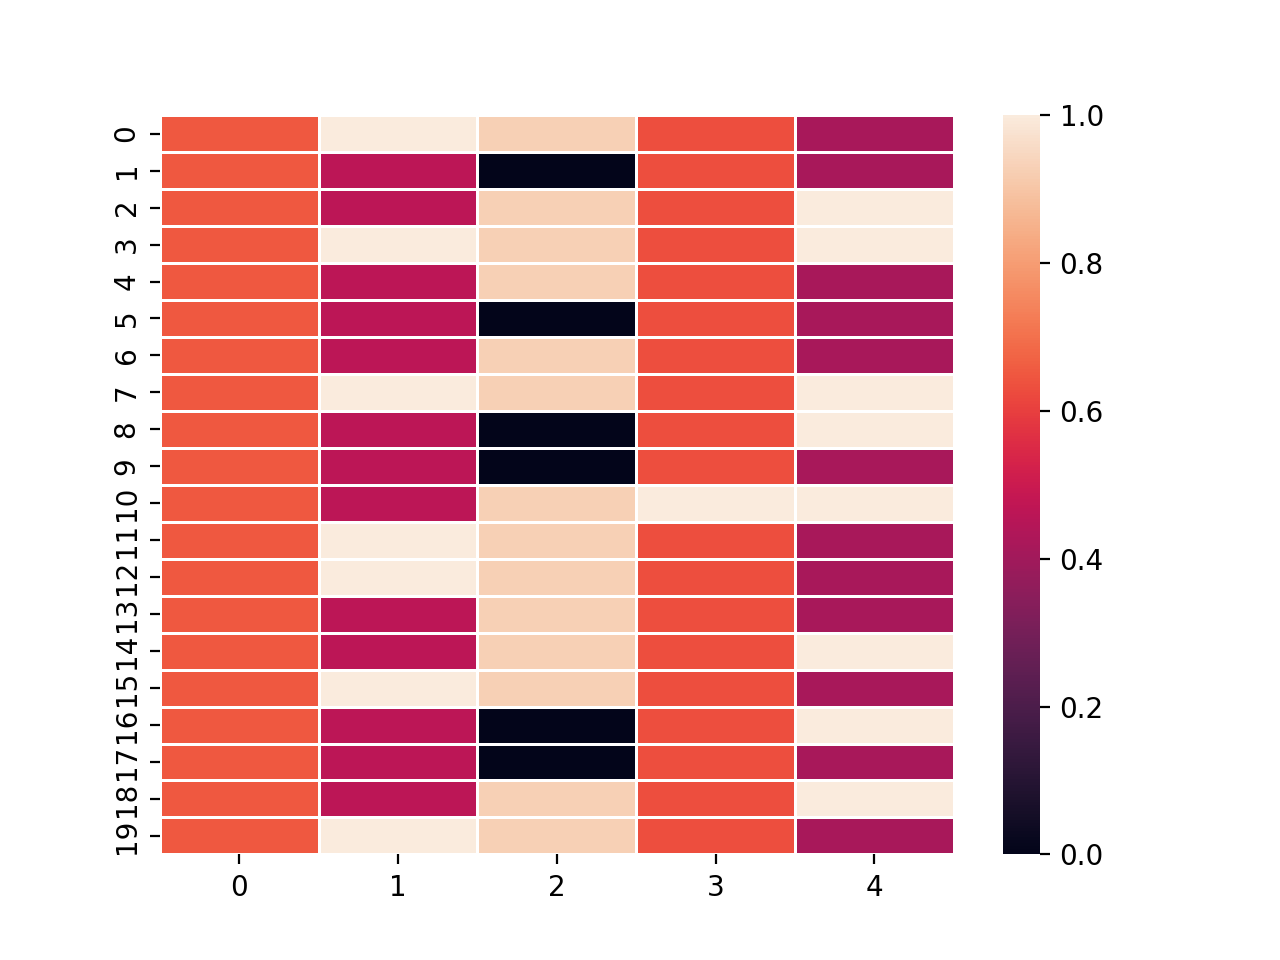

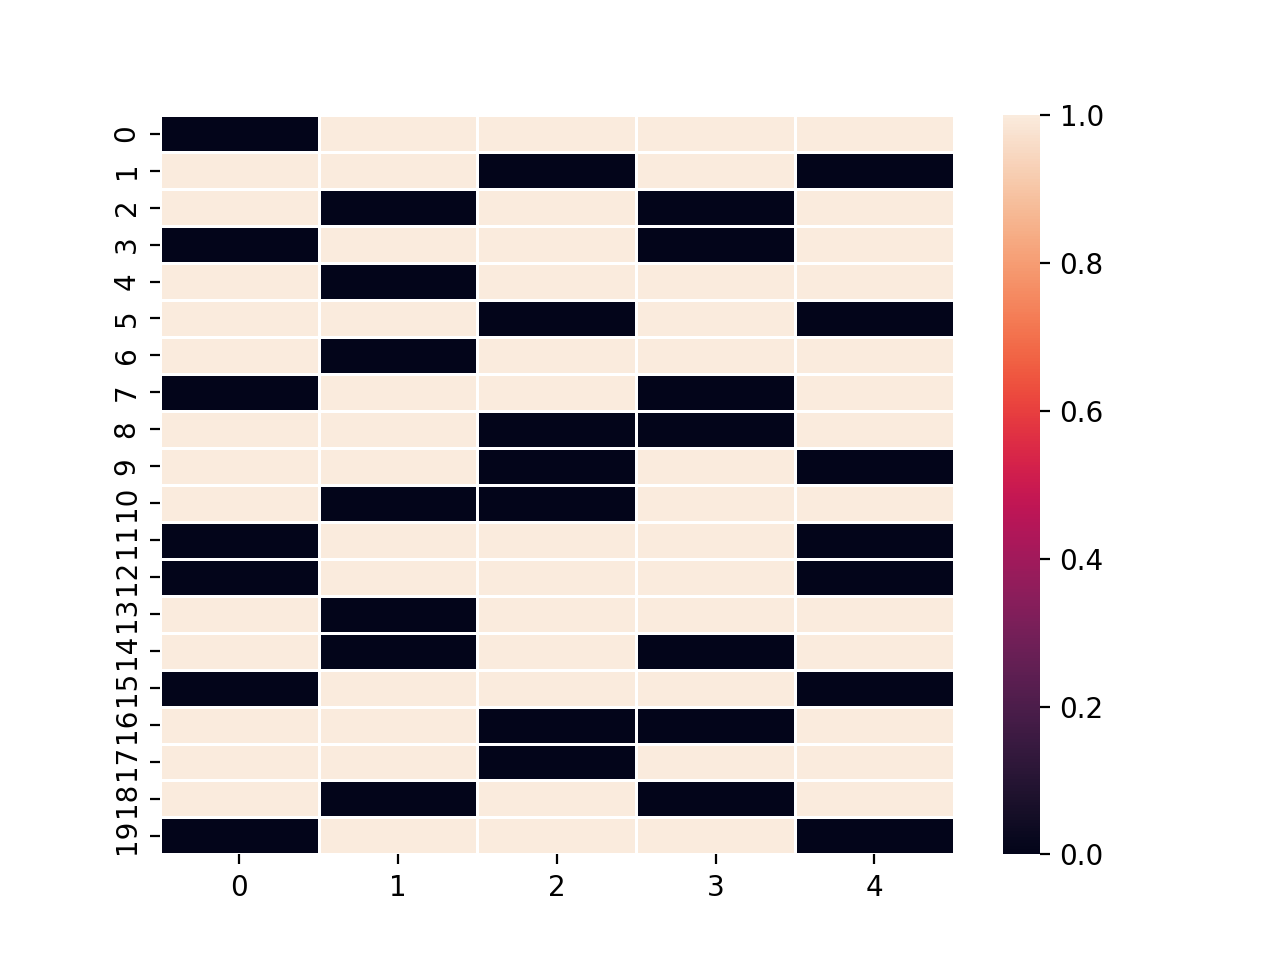

In [85]:
demo_pool.plot_winners()

In [75]:
key, subkey = random.split(key)
scores = random.poisson(subkey, 10, (40,))

# run another lottery, add new entrants
demo_pool.run_lottery(scores, lottery_size=13)

Array([0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 1., 0.], dtype=float32)

In [76]:
demo_pool.winners.sum(axis=0)

Array([13., 13., 13., 13., 13., 13.], dtype=float32)

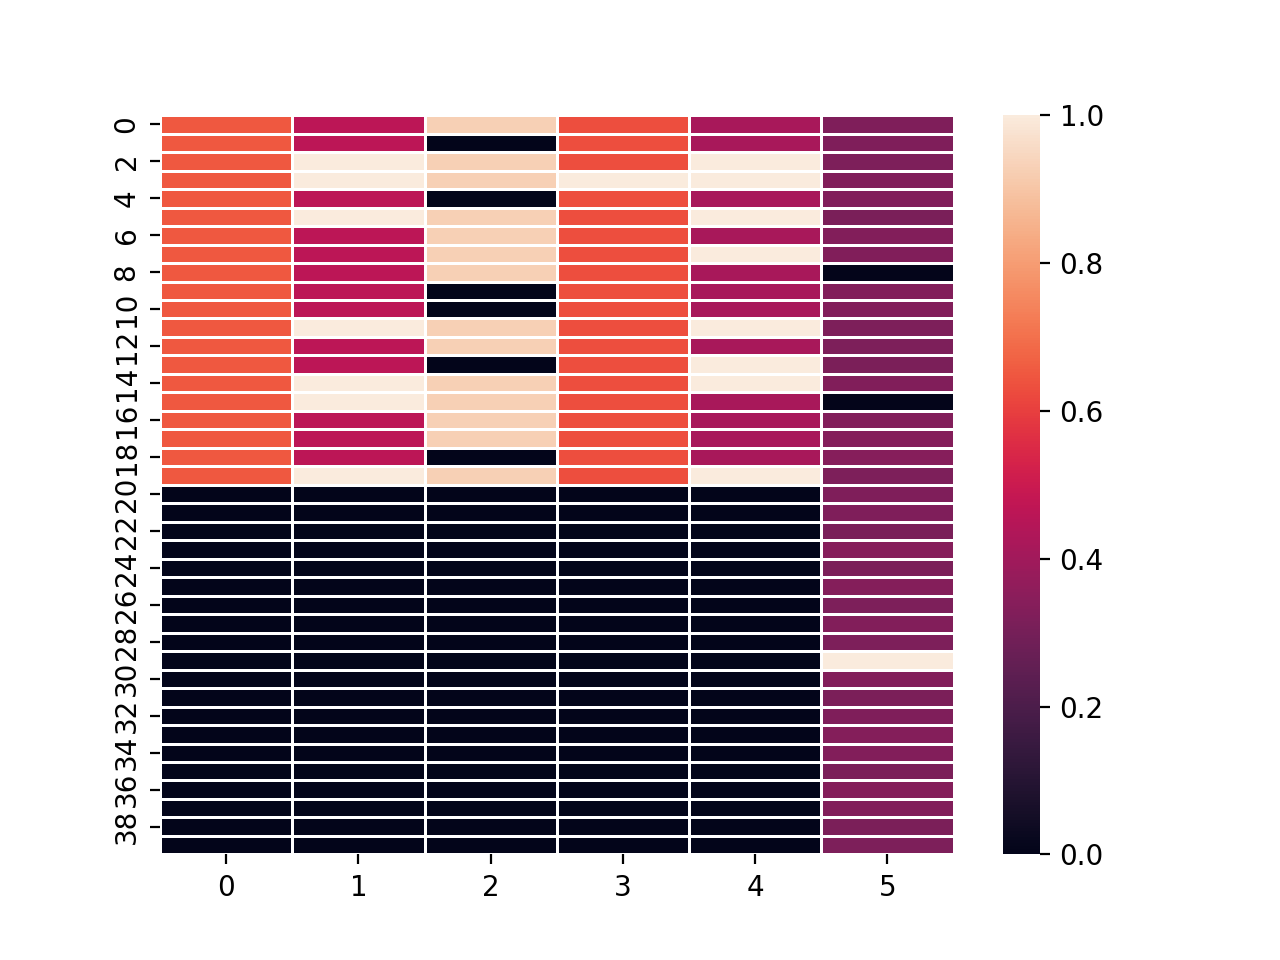

In [77]:
demo_pool.plot_win_probabilities()

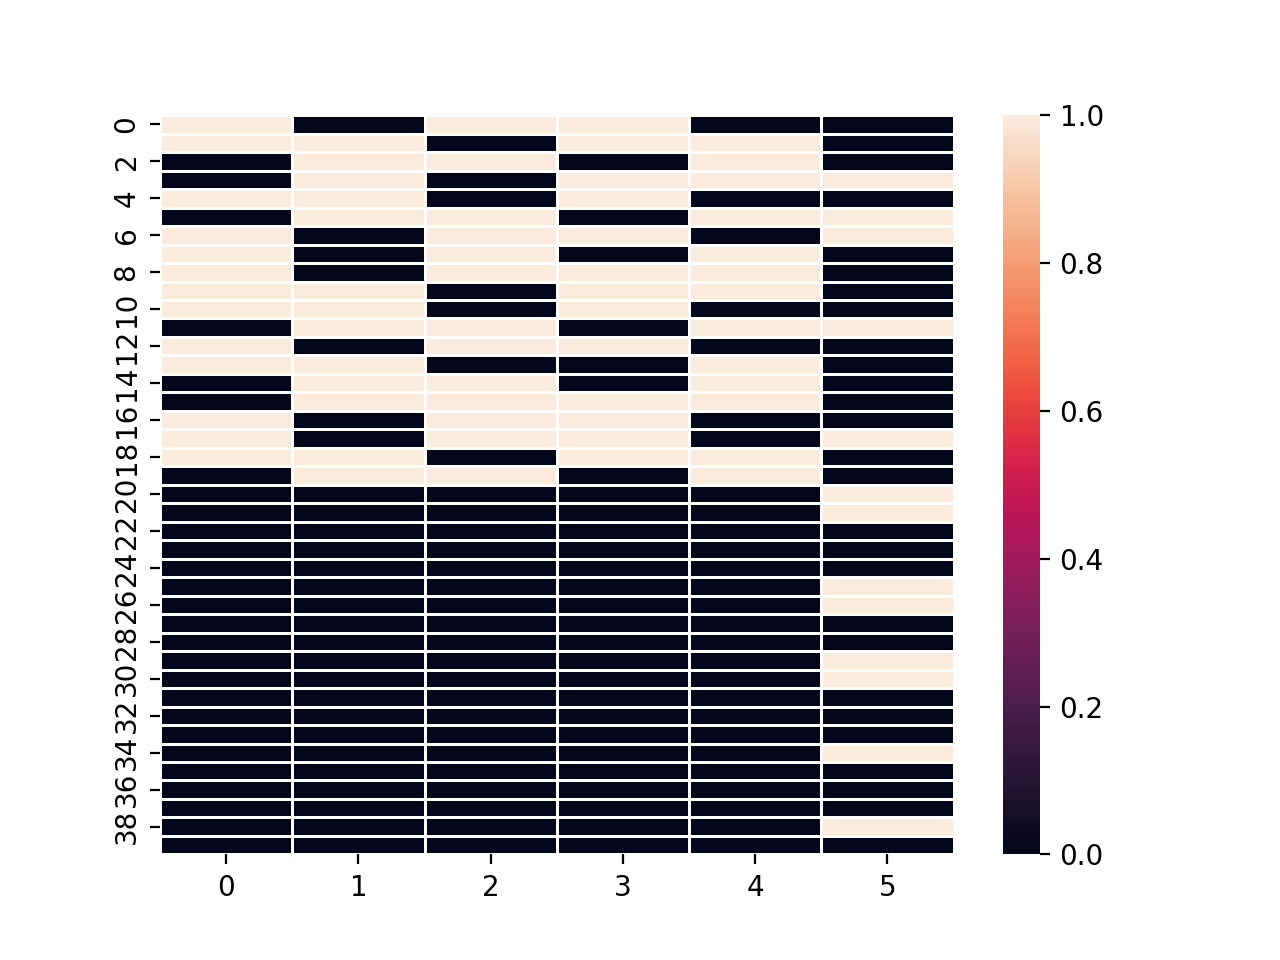

In [78]:
demo_pool.plot_winners()

ways this can break:

- if someone can apply multiple times without you realizing they are the same person, people are incentivized to just apply as many times as possible to get a slot
- if you need quotas to get a representative sample - Bailey says this should be a reasonably doable extension of her current work
- if people want to go in the future, but not now, they are motivated in the current lottery


extensions:
- waitlists: if people don't show up, count it as if they still attended
- buddies: coordinated with buddies or partner (fancy dinner for example)

who should consider implementing:
- people with sign up systems that are currently causing frustration about unfairness
- if you can id folks carefully: might help with scalping/people buying things with bots and then reselling at a much higher price
- if you have rapidly changing groups of entrants, will this feel "fair"? i don't know

- small communities make unequal distribution of resources feel less fair / when you know what other people got
- cognitive bias: "would have got in if not for the lottery"

fairness ideas: do we want to get everyone's expected number of times chosen as close as possible to the ideal, or instead everyone's *actual number of times chosen*



- Wanting to go to events with regulars so you can become a regular and have community
- Also, at the same time, wanting to go to events with new folks and to experience social variety and novelty
- Lotteries that allow ticket resale, which seems to be a fairly functional system? I'm also intrigued by FIFO ticket queues for some tickets and a lottery on the side, to potentially alleviate the "I would have been able to get a ticket if not for the lottery" feeling
- How critical it is to go to some events with buddies
- How lotteries feel bad even in comparison to first come first serve tickets because they feel less agentic
    - I proposed limited use "boosts" as one potential way around this, that pump your probability of attendance

There is potentially some interesting extension work to consider around buddies? As an extreme motivating case: suppose the current fair choice is for person A to attend with probability 1 and person B to attend with probability 0.
- What should the probability of the pair AB attending be, if you restrict admissions so that A and B either attend together or not at all. If you stick with individual level fairness, then AB will not attend, which I'm not sure is optimal! If you allow person B to be upweighted in this case, there's maybe an interesting dynamic to explore that encourages person B to find new people to bring to an event, which is an interesting design choice!
- Implementation-wise: is it easy to extend pipage rounding to the case where, for each x[i] in [0, k[i]], k[i] is a positive integer, not necessarily equal to one?

how i would hope to see this implemented at eventbrite, at marathons, etc

replace "first come, first served" time sales that become a race to click as fast as possible (who knows if businesses actually care about the customer experience here? selling out as fast as possible is probably good for them?)